# Motion of a bell

In this notebook, we solve the equations of motion for a freely swinging bell, ignoring all other effects such as the clapper, rope, ringer etc.

A freely swinging bell follows the same motions as a simple pendulum. A simple pendulum is described by the equation of motion

$$
\ddot{\theta} = - \frac{g}{l} \sin \theta
$$

where $g$ is the acceleration due to gravity (around $9.81 ms^{-2}$ at the surface of the Earth), and $l$ is the length of the pendulum. It is a famous result that the motion of the pendulum is independent of its mass.

Similarly, the motion of a bell can be described by the same equation, where the 'length' $l$ is replaced by and 'equivalent pendulum length' $l_b$. Normally a pendulum is treated in a simplified fashion, as a point-like mass at the end of a thin rod (which is assumed to have no mass), which makes finding the length $l$ very easy. A bell obviously has a very different mass distribution. The derivation of the equations in the appendix shows that we can obtain the equivalent pendulum length from three quantities, the total mass of the bell $M$, the moment of inertia of the bell about the axis of rotation $I_b$, and the distance from the axis of rotation to the centre of gravity $b$, as

$$
l_b = \frac{I_b}{Mb}
$$

In practice, none of these quantities can be determined with any accuracy for a bell -- in principle the approximate mass of the bell is stated by the bell founder, but we need to include also the mass of the headstock and wheel. The moment of interia and the location of the centre of gravity are not easy to determine. 

## Determining $l_b$

It is not difficult to determine the equivalent pendulum length $l_b$ directly, by measuring the oscillation period. If the amplitude of oscillation is small, then we can approximate $\sin \theta \simeq \theta$, and the equations of motion simplify to

$$\ddot{\theta} = - \frac{g}{l_b} \theta$$

which has the solution $\theta = A \sin \omega t$, where $A$ is the amplitude of oscillation (assumed small here), and $\omega = \sqrt{g/l_b}$ is the angular frequency. This gives the period:

$$T = 2 \pi \sqrt{\frac{l_b}{g}}$$

It isn't difficult to swing the bell gently when it is in the down position and measure this period, and hence determine $l_b$. However this formula is only correct in the limit of small amplitude. If the bell is swinging more than a few degrees, then this formula gives an incorrect answer. The *exact* period for arbitarily large amplitudes can be obtained by integrating the equation of motion over one period. However this integral cannot be expressed in terms of elementary functions, indeed, this equation of motion is essentially the defintion of the elliptic integral of the first kind, typically denoted $K(m)$,

$$T = 4 \sqrt{\frac{l_b}{g}} K(\sin^2 \theta_0/2)$$

where $\theta_0$ is the maximum angle that the bell reaches. The elliptic integral is included in the mathematics libraries of most programming languages, so there isn't really any reason to use anything other than the exact expression. However as long as the amplitude is smaller than around 90 degrees (which it surely is if you are measuring it by swinging a bell by hand), there is a good approximation described by Lima and Arun (arXiv:physics/0510206v3),

$$\begin{align}
a &=& \cos \theta_0/2 \\
T &=& 2 \pi \sqrt{\frac{l_b}{g}} \frac{\ln a}{1-a}
\end{align}
$$

A good way to determine the oscillation period is using a gyroscope, which can give very accurate results and can also determine the approximate amplitude.

# Solving the equations of motion in Python

In [1]:
%matplotlib notebook
from scipy.special import ellipk
import scipy.integrate as integrate
import numpy as np
from numpy import sqrt, sin, cos, log, pi, floor
from functools import partial
import matplotlib.pyplot as plt
from ipywidgets import interactive, FloatSlider, Layout, ToggleButton
import matplotlib.animation as animation
from IPython.display import HTML

Some constants. To see what bellringing on the moon would be like, set the acceleration
due to gravity to 1.62.  Or 24.5 for Jupiter.

In [2]:
# acceleration due to gravity
g = 9.81

To solve the equations of motion, we write them as two coupled first order differential equations for the angle $\theta$ and angular velocity $v_\theta$:

$$\begin{align}
\dot{\theta} && = && v_\theta \\
\dot{v}_\theta && = && - \frac{g}{l_b} \sin \theta
\end{align}
$$

The basic input for a differential equation solver is a function to obtain the derivatives of the variables:

In [3]:
def deriv(l_b, y, t):
    [theta, vtheta] = y
    theta_dot  = vtheta
    vtheta_dot = - (g / l_b) * sin(theta)
    return np.array([theta_dot, vtheta_dot])

Now for convenience, some functions to get the oscillation period. There is a well-known approximation for small oscillations
of a pendulum, which is independent of the amplitude (as long as the amplitude is quite small). We
also calculate an approximation that works for larger amplitudes; there are several such approximations
that have been proposed, here we use the Lima-Arun formula, from arXiv:physics/0510206v3.
Finally, the *exact* period can be calculated from the elliptic integral of the first kind.

In [4]:
# period of small oscillations
def small_oscillation(l_b):
    return 2 * pi * sqrt(l_b / g)

# Lima-Arun formula, from arXiv:physics/0510206v3
def lima_arun(l_b, theta_0):
    aa = cos(theta_0/2)
    return -small_oscillation(l_b) * log(aa) / (1 - aa)

# Exact formula from elliptic integral
def exact_period(l_b, theta_0):
    return 4 * sqrt(l_b / g) * ellipk(sin(theta_0/2)**2)

The SciPy ODE solver performs quite badly, so we do our own 4th-order Runge-Kutta method

In [5]:
def rk4(f, x, t, step):
    k1 = step * f(x, t)
    x1 = x + 0.5*k1
    k2 = step * f(x1, t+0.5*step)
    x2 = x + 0.5*k2
    k3 = step * f(x2, t+0.5*step)
    x3 = x + k3;
    k4 = step * f(x3, t+step)
    return (k1 + 2*k2 + 2*k3 + k4) / 6.0

def integrate_rk4(func, y0, tindex):
    y = [np.array(y0)]
    t_last = tindex[0]
    for t in tindex[1:]:
        step = t - t_last
        y.append(y[-1] + rk4(func, y[-1], t, step))
        t_last = t
    return np.array(y)

This function produces a plot of the angle and angular velocity of the bell, given the $l_b$ and amplitude of oscillation $\theta_0$.

In [6]:
def update_bell_plot(theta_0, l_b):
    global fig1, fig1_ax1, fig1_ax2
    Texact = exact_period(l_b, theta_0 * pi/180)
    t = np.linspace(0, 2.5*Texact, 1000)
    y0 = [theta_0 * pi/180, 0]
    y = integrate_rk4(partial(deriv, l_b), y0, t)
    fig1_ax1.clear()
    fig1_ax1.set_xlabel('t')
    fig1_ax1.set_ylabel('angle', color='b')
    fig1_ax1.plot(t, y[:,0] * 180/pi, 'b')
    fig1_ax1.grid()

    fig1_ax2.clear()
    fig1_ax2.set_ylabel('velocity', color='g')
    fig1_ax2.plot(t, y[:,1] * 180/pi, 'g')
    fig1_ax2.grid()

    fig1.tight_layout()
    fig1.canvas.draw()

    print('Period of small oscillations: {:.4} seconds'.format(small_oscillation(l_b)))
    print('Lima-Arun approximation for the period: {:.4}'.\
          format(lima_arun(l_b, theta_0*pi/180)))
    print('Exact period: {:.4}'.format(Texact))

## Interactive plot

<IPython.core.display.Javascript object>


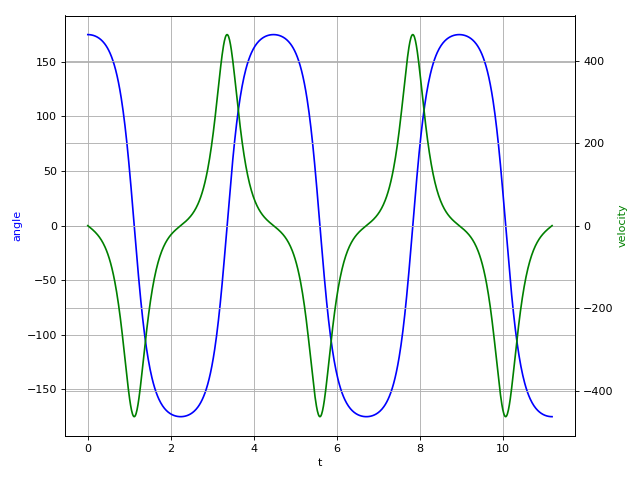

interactive(children=(FloatSlider(value=175.0, continuous_update=False, description='\\(\\theta_0\\)', layout=Layout(height='20px', width='80%'), max=179.99, min=0.01, step=0.01), FloatSlider(value=0.6, continuous_update=False, description='\\(l_b\\)', layout=Layout(height='20px', width='80%'), max=5.0, min=0.01, step=0.01), Output()), _dom_classes=('widget-interact',))

In [7]:
fig1, fig1_ax1 = plt.subplots(figsize=(8,6), dpi=80);
fig1_ax2 = fig1_ax1.twinx();

mylayout = Layout(width='80%', height='20px')
theta_0_float = FloatSlider(description=r'\(\theta_0\)', \
                        min=0.01, max=179.99, step=0.01, value=175, \
                        continuous_update=False, layout=mylayout)
l_b_float = FloatSlider(description=r'\(l_b\)', \
                        min=0.01, max=5, step=0.01, value=0.6, \
                        continuous_update=False, layout=mylayout)
interactive(update_bell_plot, theta_0=theta_0_float, l_b=l_b_float)
#update_bell_plot(0.6, 170)

## Accelerometer

We now plot the signal as measured by an accelerometer if it is placed on the bell at an angle $\beta$ from the centre line of the bell, at a distance $r$ from the axis. We assume that the axes of the accelerometer are at angle $\delta$ relative to the direction of the axis of the bell. This means that if the accelerometer is placed such that the $Y$-axis is vertical, then we have $\delta = \beta$.

Firstly for the case of $\delta = 0$, meaning the $Y$-axis is pointed towards the axis of the bell. The acceleration is (note sign chang in the original notes equation (49), if we are accelerating with positive $\ddot{\theta}$ then the accelerometer measures $-x$.  This is for consistency with the direction of gravity - we're actually accelerating upwards but conventionally we write gravity pointing down. TODO: I don't like this, fix it).

$$\begin{align}
\ddot{x} & = & - g \sin (\theta + \beta) + \frac{r g \sin \theta}{l_b} \\
\ddot{y} & = & -r v_\theta^2 - g \cos (\theta + \beta)
\end{align}
$$

A non-zero $\delta$ is just a rotation of these coordinates which we label $x'$, $y'$, which is

$$\begin{align}
\ddot{x}' &=& \ddot{x} \cos \delta - \ddot{y} \sin \delta \\
\ddot{y}' &=& = \ddot{x} \sin \delta + \ddot{y} \cos \delta
\end{align}
$$

In [8]:
def x_accel(theta, l_b, beta, r):
    return -g * sin(theta + beta) + r*g*sin(theta) / l_b

def y_accel(theta, v_theta, beta, r):
    return -r*v_theta**2 - g*cos(theta+beta)

def accel_rot(theta, v_theta, l_b, beta, r, delta):
    xddot = x_accel(theta, l_b, beta, r)
    yddot = y_accel(theta, v_theta, beta, r)
    return np.array([xddot*cos(delta) - yddot*sin(delta), \
                     xddot*sin(delta) + yddot*cos(delta)])

In [9]:
def update_accel(theta_0, l_b, beta, r, delta):
    Texact = exact_period(l_b, theta_0 * pi/180)
    t = np.linspace(0, 2.5*Texact, 1000)
    y0 = [theta_0 * pi/180, 0]
    y = integrate.odeint(partial(deriv, l_b), y0, t)
    fig2_ax1.clear()
    fig2_ax1.set_xlabel('t')
    fig2_ax1.plot(t, y[:,0] * 180/pi, 'b', label='angle')
    fig2_ax1.plot(t, y[:,1] * 180/pi, 'g', label='velocity')
    fig2_ax1.grid()
    fig2_ax1.legend(loc='best')
    
    fig2_ax2.clear()
    accel_coords = []
    for yx in y:
        accel_coords.append(accel_rot(yx[0], yx[1], l_b, beta*pi/180, r, delta*pi/180))
    accel_coords = np.array(accel_coords)
    fig2_ax2.plot(t, accel_coords[:,0], 'Red', label='X acceleration')
    fig2_ax2.plot(t, accel_coords[:,1], 'Black', label='Y acceleration')
    fig2_ax2.grid()
    fig2_ax2.legend(loc='best')
    fig2.tight_layout()
    fig2.canvas.draw()
    print('Period of small oscillations: {:.4} seconds'.format(small_oscillation(l_b)))
    print('Lima-Arun approximation for the period: {:.4}'.\
          format(lima_arun(l_b, theta_0*pi/180)))
    print('Exact period: {:.4}'.format(Texact))

<IPython.core.display.Javascript object>


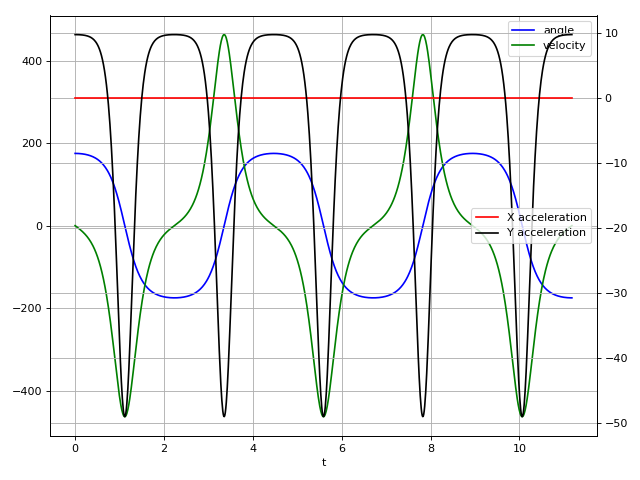

interactive(children=(FloatSlider(value=175.0, continuous_update=False, description='\\(\\theta_0\\)', layout=Layout(height='20px', width='80%'), max=179.99, min=0.01, step=0.01), FloatSlider(value=0.6, continuous_update=False, description='\\(l_b\\)', layout=Layout(height='20px', width='80%'), max=5.0, min=0.01, step=0.01), FloatSlider(value=0.0, continuous_update=False, description='\\(\\beta\\)', layout=Layout(height='20px', width='80%'), max=180.0, min=-180.0), FloatSlider(value=0.6, continuous_update=False, description='\\(r\\)', layout=Layout(height='20px', width='80%'), max=5.0, step=0.01), FloatSlider(value=0.0, continuous_update=False, description='\\(\\delta\\)', layout=Layout(height='20px', width='80%'), max=180.0, min=-180.0), Output()), _dom_classes=('widget-interact',))

In [10]:
fig2, fig2_ax1 = plt.subplots(figsize=(8,6),dpi=80)
fig2_ax2 = fig2_ax1.twinx()

beta_float = FloatSlider(description=r'\(\beta\)', \
                        min=-180, max=180, step=0.1, value=0, \
                        continuous_update=False, layout=mylayout)
r_float = FloatSlider(description=r'\(r\)', \
                        min=0, max=5, step=0.01, value=0.6, \
                        continuous_update=False, layout=mylayout)
delta_float = FloatSlider(description=r'\(\delta\)', \
                        min=-180, max=180, step=0.1, value=0, \
                        continuous_update=False, layout=mylayout)
interactive(update_accel, theta_0=theta_0_float, l_b=l_b_float, beta=beta_float, \
            r=r_float, delta=delta_float)

## Accelerometer placement

There are some special positions for the accelerometer. The default values in the plot above locate the accelerometer at distance $r = l_b$ at angle $\beta = 0$. This is at the 'pendulum distance' on the bell side of the headstock. At this position, it is easy to see that for a freely swinging bell the $x$ acceleration is identically zero. Indeed, the $x$ acceleration here measures exactly the forces acting on the bell. 

At this position ($r = l_b$, $\beta = 0$), the $y$ component of the acceleration measures a component due to gravity that is the cosine of the angle, and a component proportional to the square of the velocity of the bell. Thus, if there is also a gyro attached to the bell then the velocity is known and the angle of the bell can be determined quite easily.

This was my original idea for a pullometer, but it turns out that it is very difficult to position and calibrate the sensor in this position -- it is very sensitive to small changes in $\beta$, $\delta$ and $r$.

There is a second 'magic' position for the sensor, which is on the stay side of the bell ($\beta=180$) and at a distance $r = l_b/2$. In this position, the $y$ force is a constant when the bell is in free motion, because the centrifugal force exactly balances with gravity. The $x$ acceleration is proportional to $-\sin \theta$ plus the external forces. With the accelerometer at this position, there is no simple way to determine the angle of the bell and separate out this term from the exernal forces, so even if the sensor could be placed accurately at this position, it doesn't provide so much useful information.